# Stock Market Analysis with SVM

In [3]:
import yfinance as yf
import pandas as pd
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [4]:
# Fetch historical data for a stock
data = yf.download('AAPL', start='2020-01-01', end='2024-01-01')
data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,74.059998,75.150002,73.797501,75.087502,73.059410,135480400
2020-01-03,74.287498,75.144997,74.125000,74.357498,72.349136,146322800
2020-01-06,73.447502,74.989998,73.187500,74.949997,72.925613,118387200
2020-01-07,74.959999,75.224998,74.370003,74.597504,72.582672,108872000
2020-01-08,74.290001,76.110001,74.290001,75.797501,73.750237,132079200


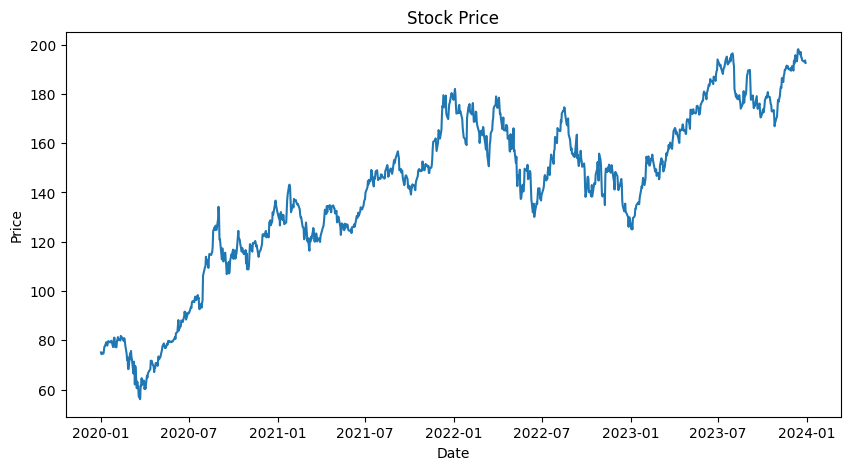

In [5]:
data = data[['Close']]  # Focus on the closing prices

# Visualize the data
plt.figure(figsize=(10, 5))
plt.plot(data['Close'])
plt.title('Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [7]:
# Generate features for SVM 
data.loc[:, 'Previous Close'] = data['Close'].shift(1)
data.loc[:,'Return'] = (data['Close'] - data['Previous Close']) / data['Previous Close']

# Calculate Moving Averages
data.loc[:, 'MA_10'] = data['Close'].rolling(window=10).mean()
data.loc[:, 'MA_50'] = data['Close'].rolling(window=50).mean()

# Calculate RSI
delta = data['Close'].diff(1)
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
data.loc[:, 'RSI'] = 100 - (100 / (1 + rs))

# Calculate MACD
exp1 = data['Close'].ewm(span=12, adjust=False).mean()
exp2 = data['Close'].ewm(span=26, adjust=False).mean()
macd = exp1 - exp2
data.loc[:, 'MACD'] = macd
data.loc[:, 'Signal'] = macd.ewm(span=9, adjust=False).mean()

data.dropna(inplace=True)  # Remove any NaNs

In [15]:
# Prepare data for SVM
feature_list = ['Return', 'MA_10', 'MA_50', 'RSI', 'MACD', 'Signal']
X = data[feature_list]
y = data['Close']  # Target variable (could also predict returns etc.)

In [17]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(X_train_scaled.shape, y_train.shape)
print(X_test_scaled.shape, y_test.shape)

(726, 6) (726,)
(182, 6) (182,)


In [18]:
# Create and train the SVM model
model = SVR(kernel='linear')
model.fit(X_train_scaled, y_train)

# Save the model
import joblib
joblib.dump(model, '../out/stockmarket_svm_model.pkl')

['../out/stockmarket_svm_model.pkl']

4.277157963125326


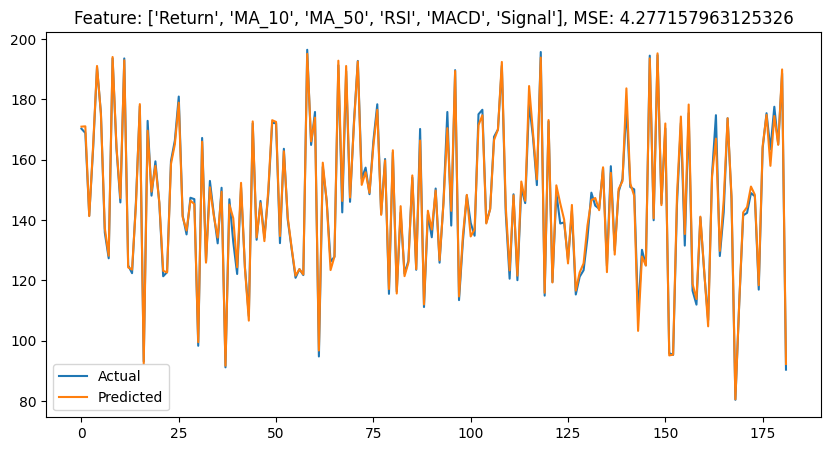

In [19]:
# Predict using the trained model
predictions = model.predict(X_test_scaled)

# Assess the model (you can use various metrics depending on your objective)
from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_test, predictions))

# Plot a mean_squared_error
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.title(f'Feature: {feature_list}, MSE: {mean_squared_error(y_test, predictions)}')
plt.show()
